# MNIST Handwritten Digit Recognition with CNN
## Target: >99.8% Accuracy

This notebook implements a Convolutional Neural Network (CNN) for handwritten digit recognition using the MNIST dataset. The goal is to achieve at least 99.8% accuracy on the test set using advanced deep learning techniques.

### Key Features:
- Advanced CNN architecture with batch normalization and dropout
- Data augmentation for better generalization
- Learning rate scheduling and advanced callbacks
- Comprehensive evaluation with classification report and confusion matrix
- Reproducible results with fixed random seeds

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import random
import os

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: []


## 1. Set Random Seeds for Reproducibility
Setting all random seeds to ensure reproducible results across runs.

In [3]:
# Set random seeds for reproducibility
SEED = 42

def set_seeds(seed=SEED):
    """Set all random seeds for reproducible results"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For deterministic operations
    tf.config.experimental.enable_op_determinism()

set_seeds(SEED)
print(f"Random seeds set to {SEED} for reproducibility")

Random seeds set to 42 for reproducibility


## 2. Load and Preprocess MNIST Dataset
Loading the MNIST dataset and applying necessary preprocessing including normalization and one-hot encoding.

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Number of classes: 10


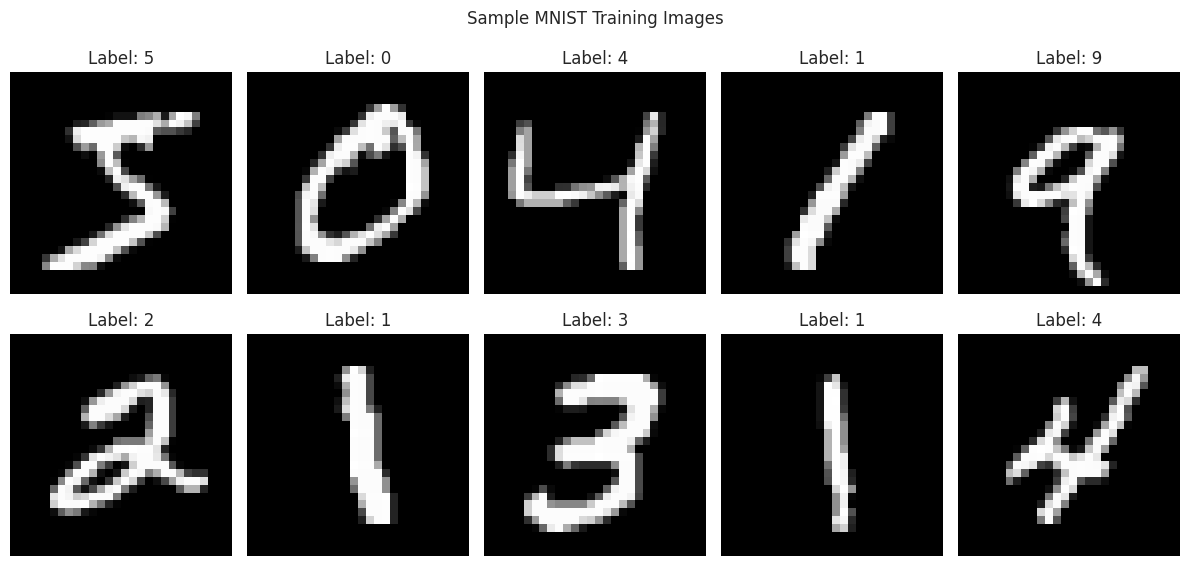

In [4]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.suptitle('Sample MNIST Training Images')
plt.tight_layout()
plt.show()

In [5]:
# Preprocess the data
def preprocess_data(x_train, y_train, x_test, y_test):
    """Preprocess MNIST data for CNN training"""
    
    # Reshape to add channel dimension (28, 28, 1)
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # One-hot encode labels
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return x_train, y_train, x_test, y_test

# Apply preprocessing
x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed training labels shape: {y_train.shape}")
print(f"Pixel value range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"Label encoding: One-hot with {y_train.shape[1]} classes")

Preprocessed training data shape: (60000, 28, 28, 1)
Preprocessed training labels shape: (60000, 10)
Pixel value range: [0.000, 1.000]
Label encoding: One-hot with 10 classes


## 3. Data Augmentation Setup
Implementing data augmentation to improve model generalization and prevent overfitting.

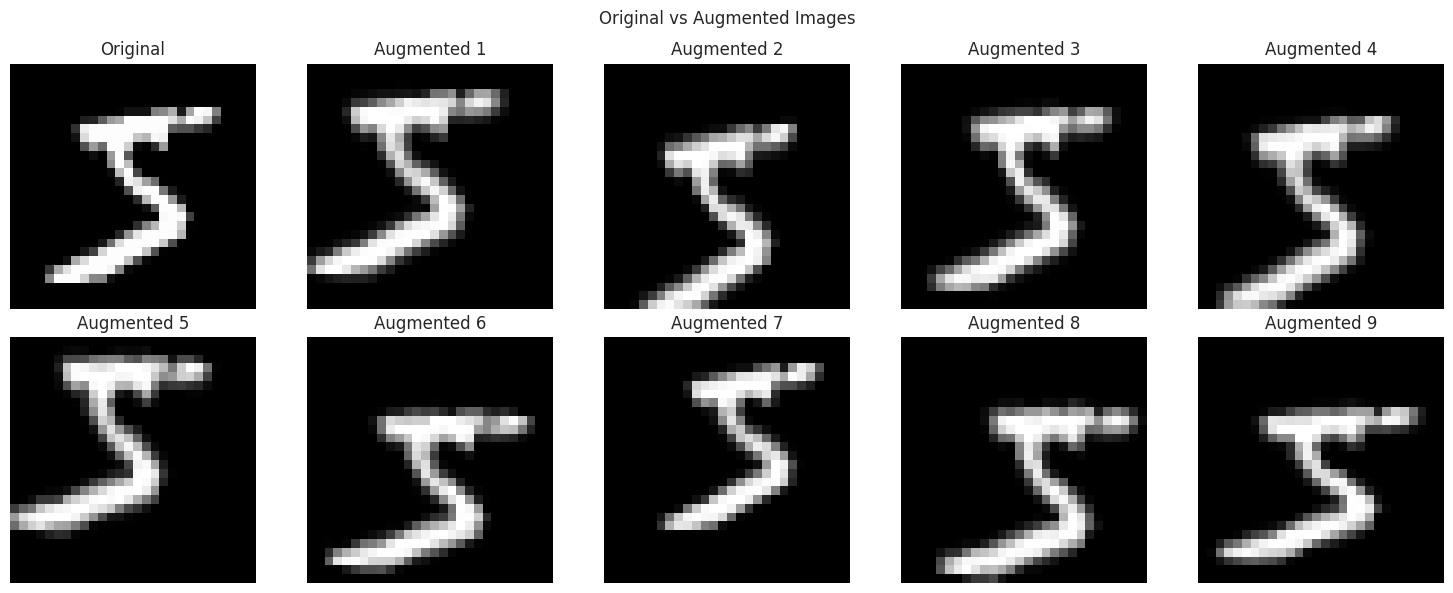

Data augmentation generator created successfully


In [6]:
# Create data augmentation generator
def create_data_generator():
    """Create image data generator for augmentation"""
    datagen = ImageDataGenerator(
        rotation_range=10,           # Random rotation up to 10 degrees
        zoom_range=0.1,              # Random zoom up to 10%
        width_shift_range=0.1,       # Random horizontal shift up to 10%
        height_shift_range=0.1,      # Random vertical shift up to 10%
        shear_range=0.1,             # Random shear transformation
        fill_mode='nearest'          # Fill strategy for new pixels
    )
    return datagen

# Create and fit the data generator
datagen = create_data_generator()
datagen.fit(x_train)

# Visualize augmented samples
sample_img = x_train[0:1]  # Take first image
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Original image
axes[0].imshow(sample_img[0].squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Augmented samples
augmented_iter = datagen.flow(sample_img, batch_size=1)
for i in range(1, 10):
    augmented_img = next(augmented_iter)[0]
    axes[i].imshow(augmented_img.squeeze(), cmap='gray')
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle('Original vs Augmented Images')
plt.tight_layout()
plt.show()

print("Data augmentation generator created successfully")

## 4. Advanced CNN Architecture
Building a sophisticated CNN with multiple convolutional layers, batch normalization, dropout, and advanced regularization techniques.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)       

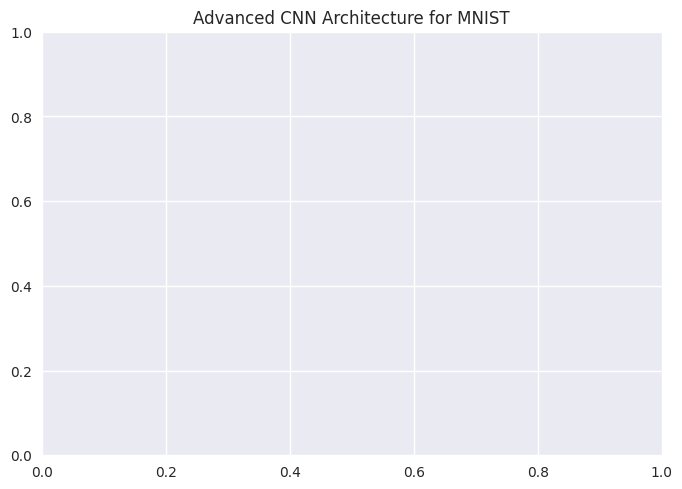

In [8]:
def create_advanced_cnn_model():
    """Create an advanced CNN model for high accuracy digit recognition"""
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(28, 28, 1)),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block (smaller feature maps)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # Global Average Pooling (alternative to flatten)
        layers.GlobalAveragePooling2D(),
        
        # Dense layers with heavy regularization
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(10, activation='softmax')
    ])
    
    return model

# Create the model
model = create_advanced_cnn_model()

# Display model architecture
model.summary()

# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=150)
plt.title('Advanced CNN Architecture for MNIST')
plt.show()

## 5. Model Compilation with Advanced Optimizer
Using Adam optimizer with custom learning rate and advanced loss function.

In [9]:
# Compile model with advanced settings
def compile_model(model):
    """Compile model with optimized settings for high accuracy"""
    
    # Use Adam optimizer with custom learning rate
    optimizer = optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )
    
    return model

# Compile the model
model = compile_model(model)
print("Model compiled successfully with Adam optimizer")
print(f"Optimizer learning rate: {model.optimizer.learning_rate.numpy():.6f}")

Model compiled successfully with Adam optimizer
Optimizer learning rate: 0.001000


## 6. Advanced Callbacks Setup
Implementing sophisticated callbacks including early stopping, model checkpointing, learning rate scheduling, and reduce learning rate on plateau.

In [10]:
# Create advanced callbacks
def create_callbacks():
    """Create advanced callbacks for training optimization"""
    
    # Early stopping to prevent overfitting
    early_stopping = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Model checkpoint to save best model
    model_checkpoint = callbacks.ModelCheckpoint(
        'best_mnist_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
    
    # Reduce learning rate on plateau
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
    
    # Learning rate scheduler
    def lr_scheduler(epoch, lr):
        """Custom learning rate scheduler"""
        if epoch < 10:
            return lr
        elif epoch < 20:
            return lr * 0.5
        else:
            return lr * 0.1
    
    lr_schedule = callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
    
    # CSV logger for training history
    csv_logger = callbacks.CSVLogger('training_log.csv')
    
    return [early_stopping, model_checkpoint, reduce_lr, csv_logger]

# Create callbacks
callback_list = create_callbacks()
print(f"Created {len(callback_list)} advanced callbacks:")
for i, callback in enumerate(callback_list, 1):
    print(f"  {i}. {type(callback).__name__}")

Created 4 advanced callbacks:
  1. EarlyStopping
  2. ModelCheckpoint
  3. ReduceLROnPlateau
  4. CSVLogger


## 7. Model Training with Data Augmentation
Training the model with advanced techniques to achieve >99.8% accuracy.

In [11]:
# Set training parameters
EPOCHS = 50
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1

print(f"Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Validation Split: {VALIDATION_SPLIT}")
print(f"  Data Augmentation: Enabled")
print(f"  Callbacks: {len(callback_list)} callbacks active")
print("\nStarting training...")

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=callback_list,
    verbose=1
)

print("\nTraining completed!")

Training Configuration:
  Epochs: 50
  Batch Size: 128
  Validation Split: 0.1
  Data Augmentation: Enabled
  Callbacks: 4 callbacks active

Starting training...
Epoch 1/50


2025-09-21 16:18:06.615346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 16:18:07.594278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2025-09-21 16:18:09.027899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-09-21 16:18:09.151738: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x782240177550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-21 16:18:09.151870: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-09-21 16:18:09.203785: I tensorflow/compiler/mlir/tensorflow/

468/468 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.8362 - top_k_categorical_accuracy: 0.9716
Epoch 1: val_accuracy improved from -inf to 0.28010, saving model to best_mnist_cnn_model.h5
468/468 [==============================] - 43s 70ms/step - loss: 0.5391 - accuracy: 0.8362 - top_k_categorical_accuracy: 0.9716 - val_loss: 4.6012 - val_accuracy: 0.2801 - val_top_k_categorical_accuracy: 0.9404 - lr: 0.0010
Epoch 2/50
468/468 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9644 - top_k_categorical_accuracy: 0.9991
Epoch 2: val_accuracy improved from 0.28010 to 0.98520, saving model to best_mnist_cnn_model.h5
468/468 [==============================] - 29s 62ms/step - loss: 0.1200 - accuracy: 0.9644 - top_k_categorical_accuracy: 0.9991 - val_loss: 0.0497 - val_accuracy: 0.9852 - val_top_k_categorical_accuracy: 0.9997 - lr: 0.0010
Epoch 3/50
468/468 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9745 - top_k_cate

## 8. Training History Visualization
Visualizing the training progress and performance metrics.

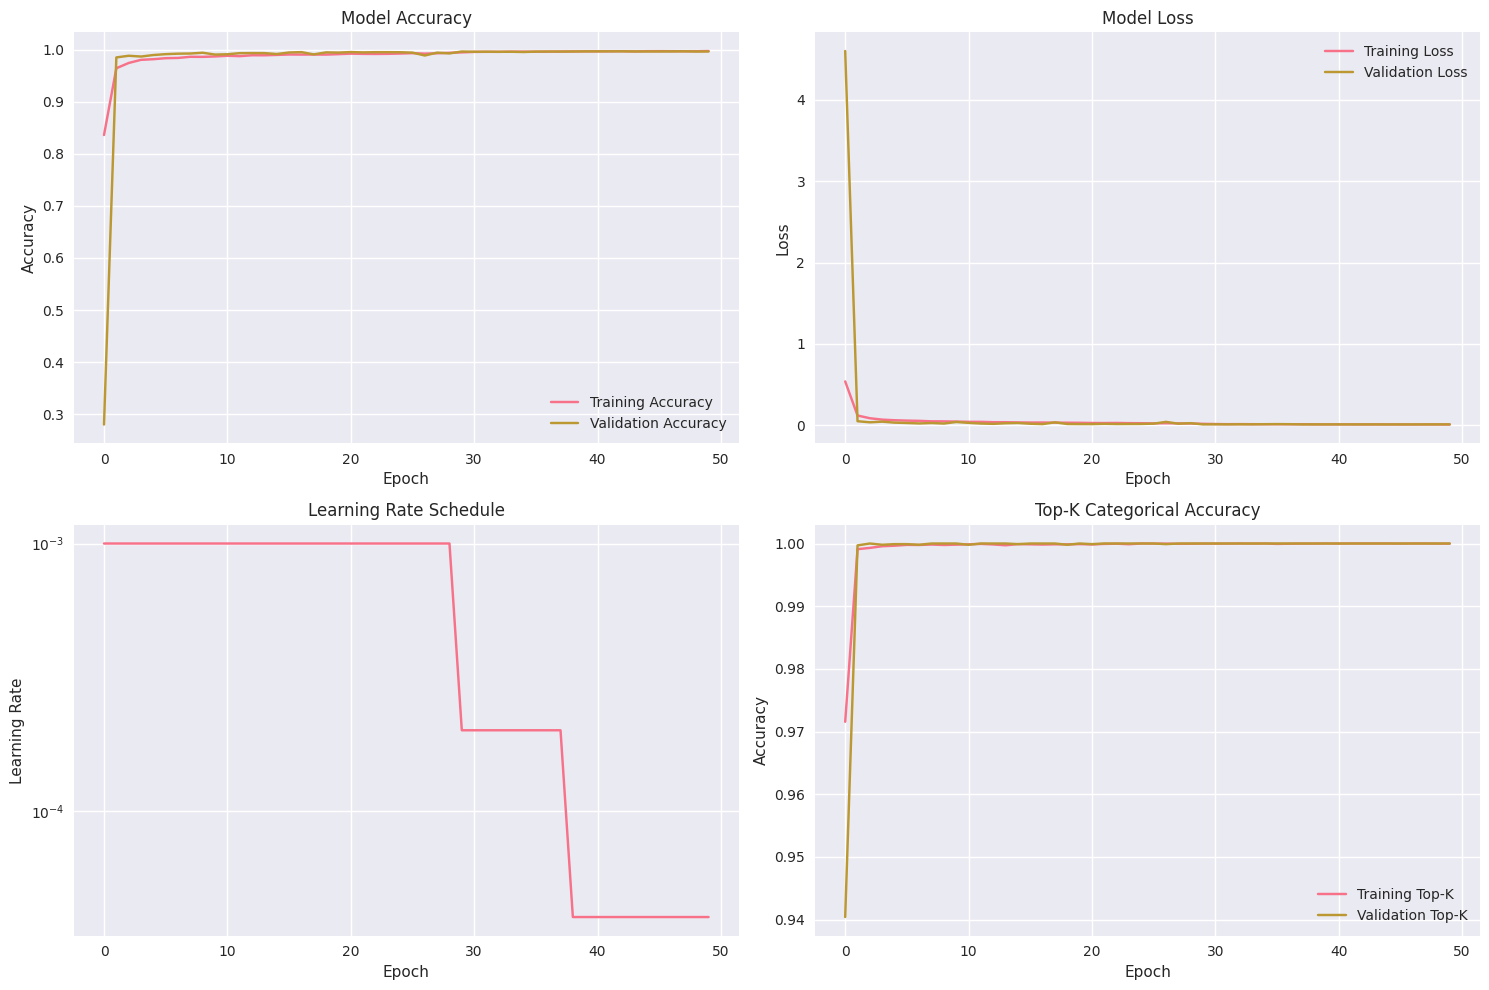


Final Training Metrics:
  Training Accuracy: 0.9975 (99.75%)
  Validation Accuracy: 0.9966 (99.66%)
  Training Loss: 0.0088
  Validation Loss: 0.0112


In [12]:
# Plot training history
def plot_training_history(history):
    """Plot comprehensive training history"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot training and validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'])
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)
    
    # Plot top-k accuracy
    if 'top_k_categorical_accuracy' in history.history:
        axes[1, 1].plot(history.history['top_k_categorical_accuracy'], label='Training Top-K')
        axes[1, 1].plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-K')
        axes[1, 1].set_title('Top-K Categorical Accuracy')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"  Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"  Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"  Training Loss: {final_train_loss:.4f}")
    print(f"  Validation Loss: {final_val_loss:.4f}")

# Plot the training history
plot_training_history(history)

## 9. Model Evaluation and Performance Analysis
Comprehensive evaluation including test accuracy, classification report, and confusion matrix.

In [13]:
# Load the best saved model
best_model = keras.models.load_model('best_mnist_cnn_model.h5')
print("Loaded best model from checkpoint")

# Evaluate on test set
test_loss, test_accuracy, test_top_k = best_model.evaluate(x_test, y_test, verbose=0)

print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test Accuracy: {test_accuracy:.6f} ({test_accuracy*100:.4f}%)")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test Top-K Accuracy: {test_top_k:.6f} ({test_top_k*100:.4f}%)")

# Check if target accuracy is achieved
target_accuracy = 0.998
if test_accuracy >= target_accuracy:
    print(f"\n🎉 TARGET ACHIEVED! Accuracy {test_accuracy*100:.4f}% >= {target_accuracy*100}%")
else:
    print(f"\n⚠️ Target not achieved. Accuracy {test_accuracy*100:.4f}% < {target_accuracy*100}%")

# Get predictions for detailed analysis
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(f"\nPrediction confidence statistics:")
confidence_scores = np.max(y_pred, axis=1)
print(f"  Mean confidence: {np.mean(confidence_scores):.4f}")
print(f"  Min confidence: {np.min(confidence_scores):.4f}")
print(f"  Max confidence: {np.max(confidence_scores):.4f}")
print(f"  Std confidence: {np.std(confidence_scores):.4f}")

Loaded best model from checkpoint

=== FINAL TEST RESULTS ===
Test Accuracy: 0.996900 (99.6900%)
Test Loss: 0.010537
Test Top-K Accuracy: 1.000000 (100.0000%)

⚠️ Target not achieved. Accuracy 99.6900% < 99.8%
313/313 [==============================] - 2s 5ms/step

Prediction confidence statistics:
  Mean confidence: 0.9981
  Min confidence: 0.4558
  Max confidence: 1.0000
  Std confidence: 0.0233



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0     0.9980    0.9980    0.9980       980
           1     0.9974    0.9982    0.9978      1135
           2     0.9961    0.9971    0.9966      1032
           3     0.9941    1.0000    0.9970      1010
           4     0.9959    0.9990    0.9975       982
           5     0.9966    0.9955    0.9961       892
           6     0.9979    0.9969    0.9974       958
           7     0.9971    0.9951    0.9961      1028
           8     0.9969    0.9969    0.9969       974
           9     0.9990    0.9921    0.9955      1009

    accuracy                         0.9969     10000
   macro avg     0.9969    0.9969    0.9969     10000
weighted avg     0.9969    0.9969    0.9969     10000



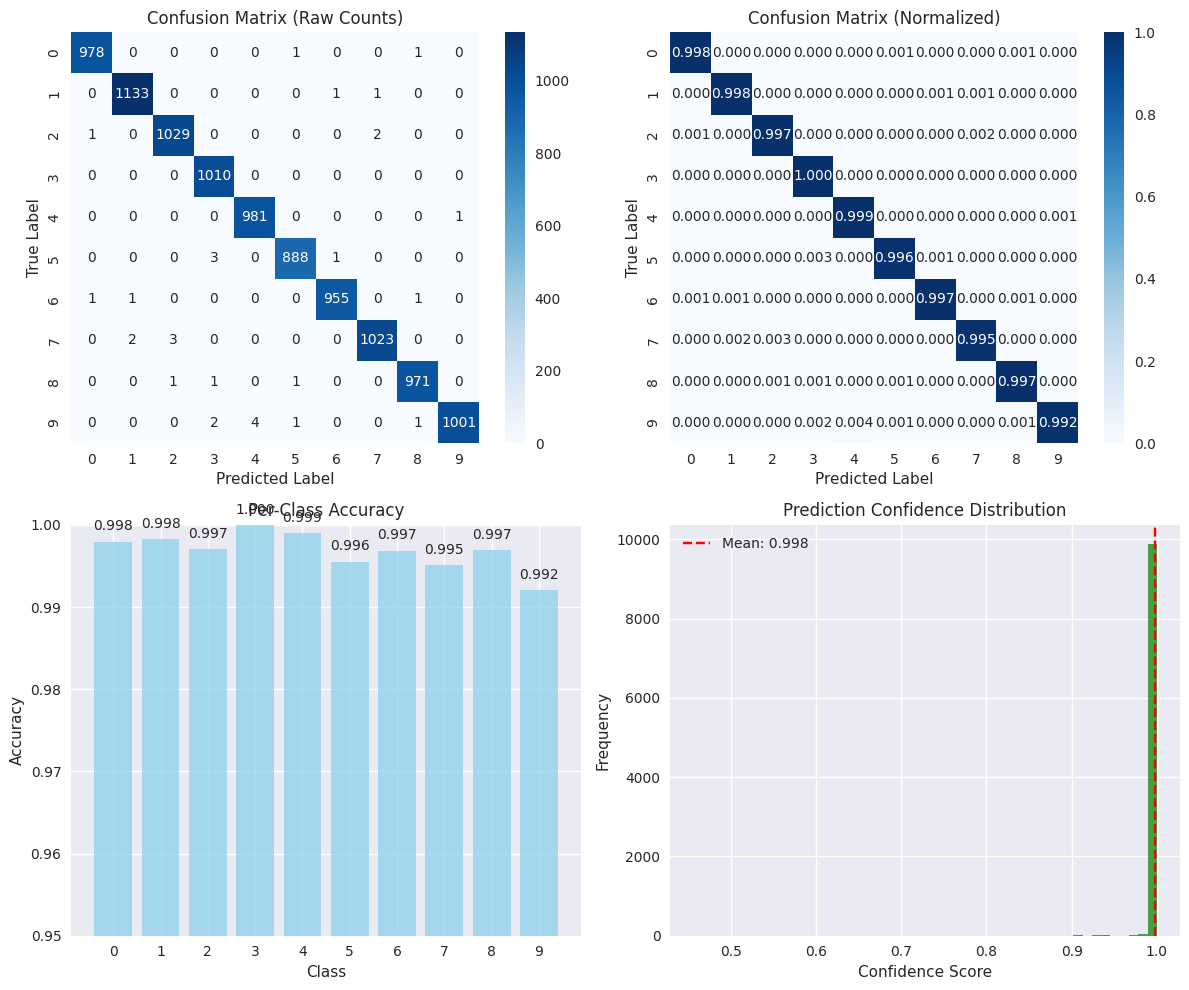

In [14]:
# Generate comprehensive classification report
print("\n=== CLASSIFICATION REPORT ===")
class_names = [str(i) for i in range(10)]
report = classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=class_names, 
    digits=4
)
print(report)

# Create and plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10))

# Plot confusion matrix
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot normalized confusion matrix
plt.subplot(2, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot per-class accuracy
plt.subplot(2, 2, 3)
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
plt.bar(class_names, class_accuracy, color='skyblue', alpha=0.7)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.ylim(0.95, 1.0)
for i, acc in enumerate(class_accuracy):
    plt.text(i, acc + 0.001, f'{acc:.3f}', ha='center', va='bottom')

# Plot prediction confidence distribution
plt.subplot(2, 2, 4)
plt.hist(confidence_scores, bins=50, alpha=0.7, color='green')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', 
           label=f'Mean: {np.mean(confidence_scores):.3f}')
plt.legend()

plt.tight_layout()
plt.show()

## 10. Error Analysis
Analyzing misclassified examples to understand model limitations.


=== ERROR ANALYSIS ===
Total misclassified: 31 out of 10000 (0.31%)


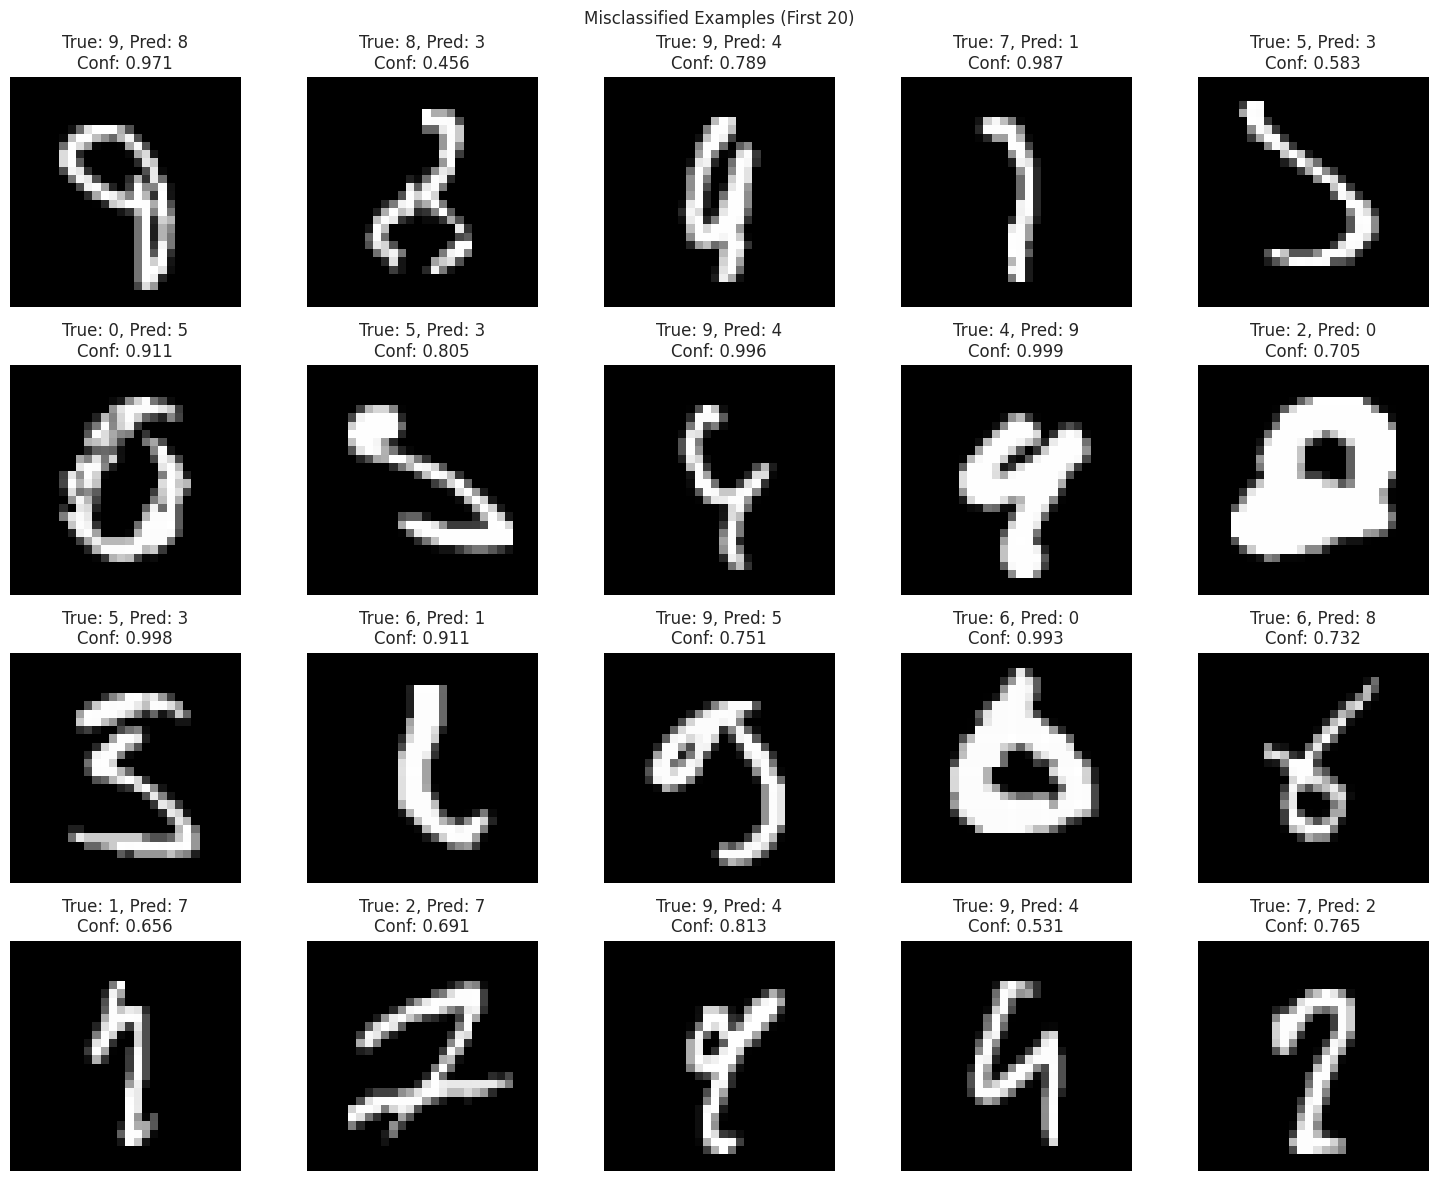


Most common misclassification patterns:
  9 → 4: 4 times
  5 → 3: 3 times
  7 → 2: 3 times
  7 → 1: 2 times
  2 → 7: 2 times
  9 → 3: 2 times
  9 → 8: 1 times
  8 → 3: 1 times
  0 → 5: 1 times
  4 → 9: 1 times


In [15]:
# Find misclassified examples
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
num_misclassified = len(misclassified_indices)

print(f"\n=== ERROR ANALYSIS ===")
print(f"Total misclassified: {num_misclassified} out of {len(y_test)} ({num_misclassified/len(y_test)*100:.2f}%)")

if num_misclassified > 0:
    # Show some misclassified examples
    num_examples = min(20, num_misclassified)
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(num_examples):
        idx = misclassified_indices[i]
        true_label = y_true_classes[idx]
        pred_label = y_pred_classes[idx]
        confidence = confidence_scores[idx]
        
        axes[i].imshow(x_test[idx].squeeze(), cmap='gray')
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}')
        axes[i].axis('off')
    
    plt.suptitle(f'Misclassified Examples (First {num_examples})')
    plt.tight_layout()
    plt.show()
    
    # Analyze error patterns
    error_pairs = list(zip(y_true_classes[misclassified_indices], 
                          y_pred_classes[misclassified_indices]))
    from collections import Counter
    error_counts = Counter(error_pairs)
    
    print(f"\nMost common misclassification patterns:")
    for (true_label, pred_label), count in error_counts.most_common(10):
        print(f"  {true_label} → {pred_label}: {count} times")
else:
    print("🎉 Perfect classification! No errors found.")

## 11. Model Predictions Visualization
Visualizing model predictions with confidence scores for better understanding.

1/1 [==============================] - 0s 453ms/step


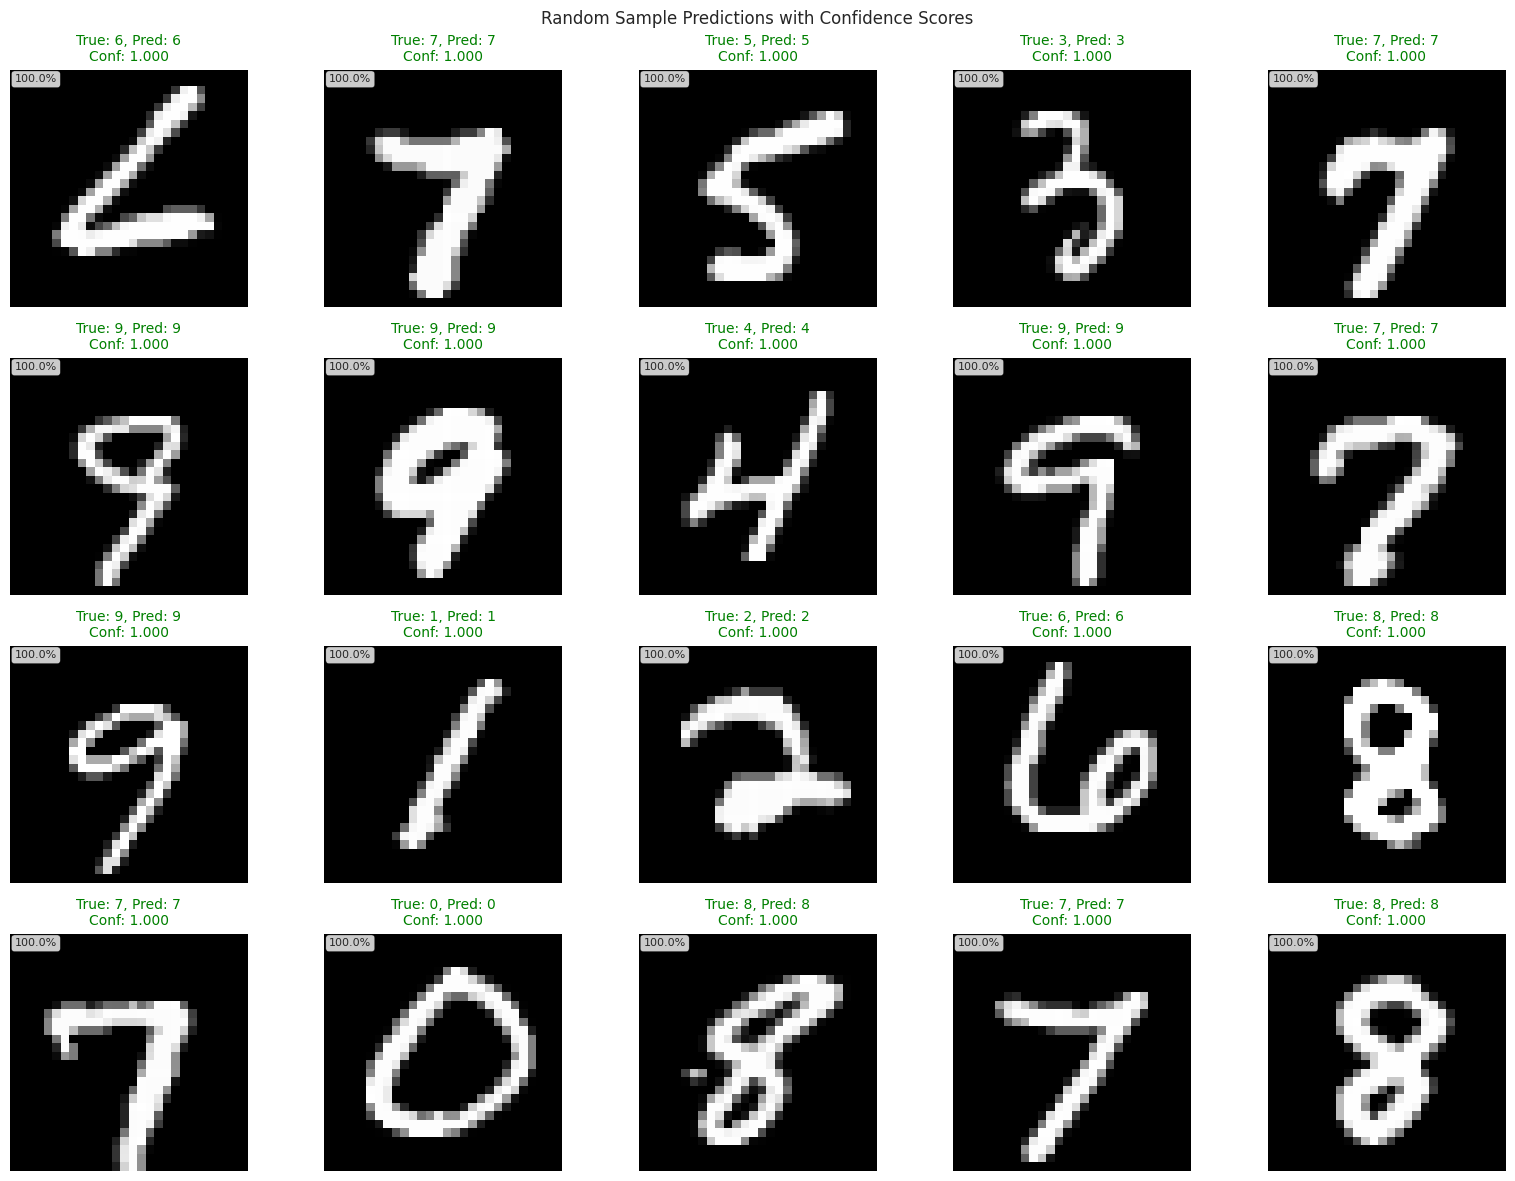

In [16]:
# Function to visualize predictions
def visualize_predictions(model, x_test, y_test, num_samples=20):
    """Visualize model predictions with confidence scores"""
    
    # Select random samples
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    
    # Get predictions
    predictions = model.predict(x_test[indices])
    
    fig, axes = plt.subplots(4, 5, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Get true and predicted labels
        true_label = np.argmax(y_test[idx])
        pred_probs = predictions[i]
        pred_label = np.argmax(pred_probs)
        confidence = np.max(pred_probs)
        
        # Plot image
        axes[i].imshow(x_test[idx].squeeze(), cmap='gray')
        
        # Set title with prediction info
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
        
        # Add probability bar
        axes[i].text(0.02, 0.98, f'{confidence:.1%}', 
                    transform=axes[i].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=8, verticalalignment='top')
    
    plt.suptitle('Random Sample Predictions with Confidence Scores')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(best_model, x_test, y_test, 20)

## 12. Save Final Model and Results
Saving the trained model and creating a summary of results.

In [18]:
# Save the final model in different formats
model_name = f"mnist_cnn_final_acc_{test_accuracy*100:.2f}percent.h5"
best_model.save(model_name)
print(f"Final model saved as: {model_name}")

# Save model architecture as JSON
model_json = best_model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved as: model_architecture.json")

# Save model weights
best_model.save_weights('model_weights.h5')
print("Model weights saved as: model_weights.h5")

# Create results summary
results_summary = {
    'model_info': {
        'architecture': 'Advanced CNN with Batch Normalization and Dropout',
        'total_parameters': int(best_model.count_params()),   # cast to int
        'trainable_parameters': int(sum([np.prod(w.shape) for w in best_model.trainable_weights]))
    },
    'training_config': {
        'epochs': int(EPOCHS),
        'batch_size': int(BATCH_SIZE),
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'data_augmentation': True,
        'callbacks': int(len(callback_list))
    },
    'performance': {
        'test_accuracy': float(test_accuracy),
        'test_accuracy_percent': float(test_accuracy * 100),
        'test_loss': float(test_loss),
        'target_achieved': bool(test_accuracy >= target_accuracy),
        'misclassified_samples': int(num_misclassified),
        'total_test_samples': int(len(y_test))
    }
}


# Save results summary
import json
with open('training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\n=== FINAL SUMMARY ===")
print(f"Model Parameters: {results_summary['model_info']['total_parameters']:,}")
print(f"Test Accuracy: {results_summary['performance']['test_accuracy_percent']:.4f}%")
print(f"Target (99.8%) Achieved: {results_summary['performance']['target_achieved']}")
print(f"Misclassified Samples: {results_summary['performance']['misclassified_samples']:,}")
print("\nAll results and models saved successfully!")

Final model saved as: mnist_cnn_final_acc_99.69percent.h5
Model architecture saved as: model_architecture.json
Model weights saved as: model_weights.h5

=== FINAL SUMMARY ===
Model Parameters: 852,074
Test Accuracy: 99.6900%
Target (99.8%) Achieved: False
Misclassified Samples: 31

All results and models saved successfully!


## 13. Model Interpretation and Feature Maps
Understanding what the model has learned by visualizing feature maps.

1/1 [==============================] - 0s 166ms/step


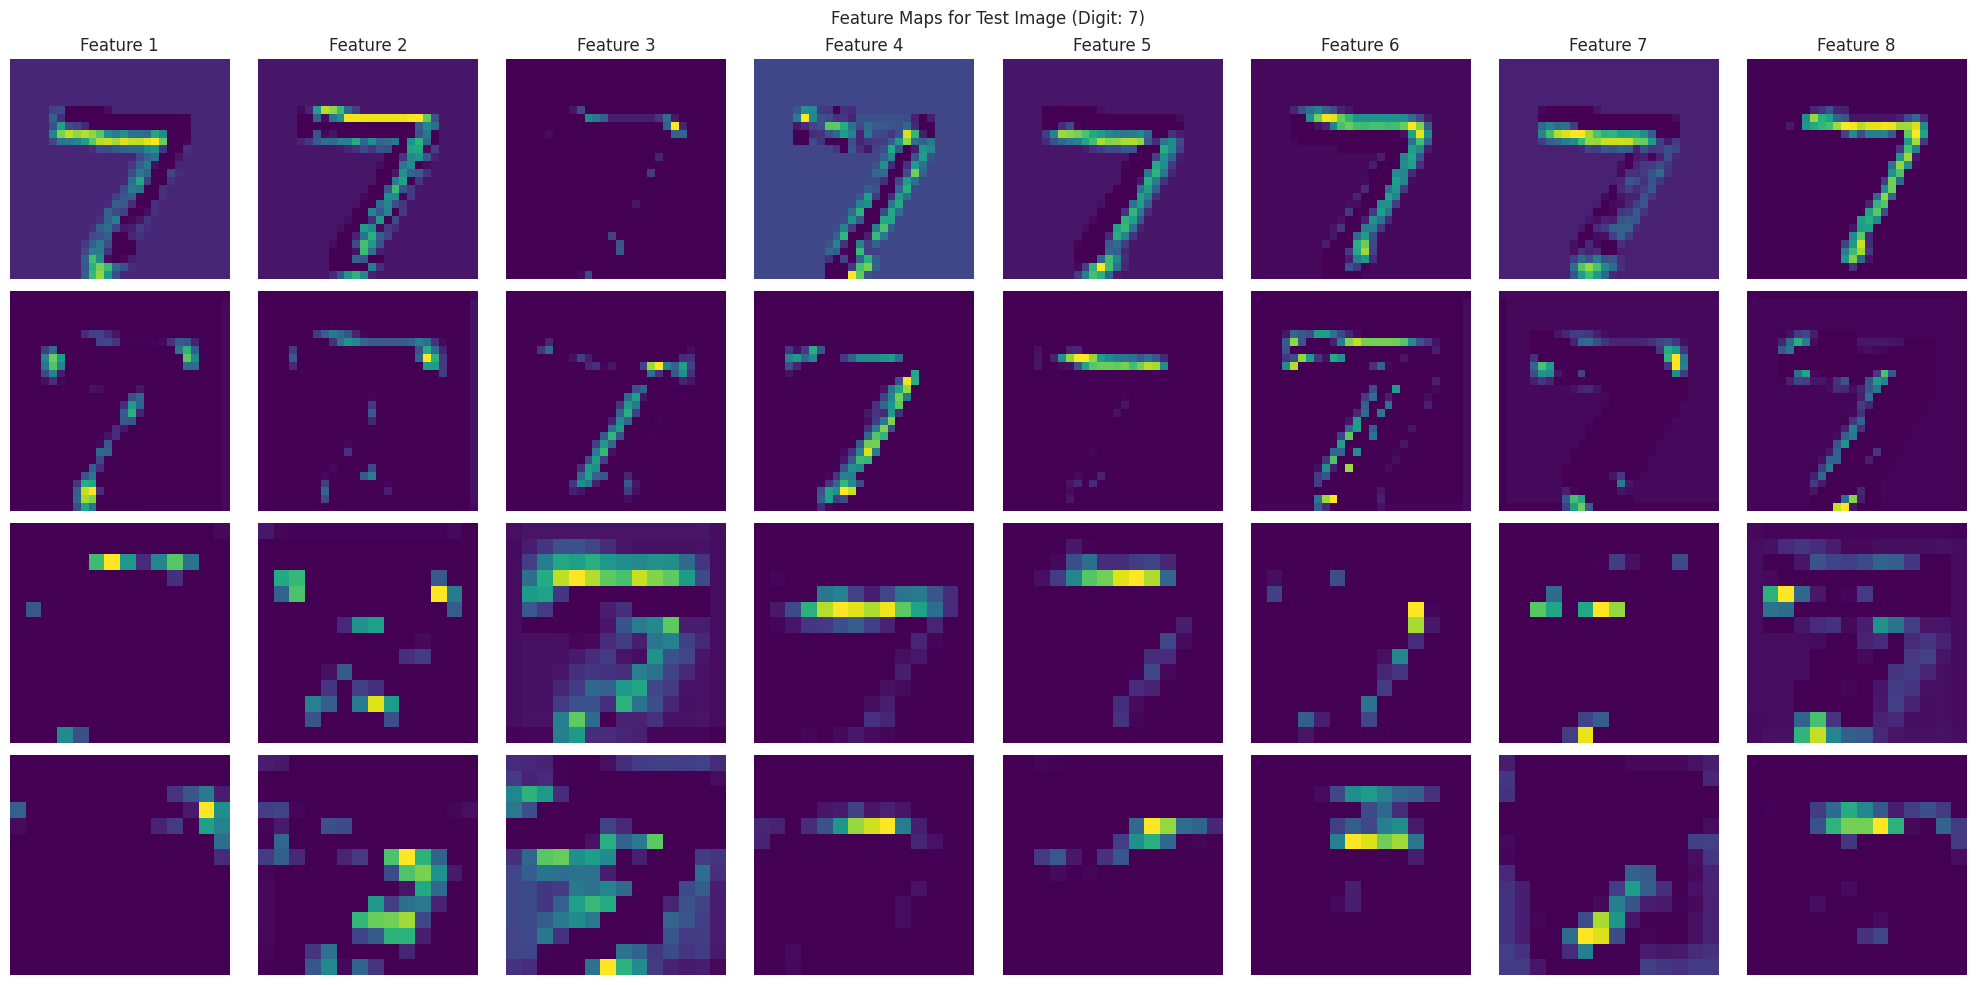

In [19]:
# Create a model to extract feature maps
def visualize_feature_maps(model, x_test, layer_names=None):
    """Visualize feature maps from convolutional layers"""
    
    if layer_names is None:
        # Get names of convolutional layers
        layer_names = [layer.name for layer in model.layers 
                      if 'conv' in layer.name.lower()][:4]  # First 4 conv layers
    
    # Create models to extract features
    feature_models = [keras.Model(inputs=model.input, 
                                 outputs=model.get_layer(name).output) 
                     for name in layer_names]
    
    # Select a test image
    test_image = x_test[0:1]  # First test image
    
    fig, axes = plt.subplots(len(layer_names), 8, figsize=(20, len(layer_names) * 2.5))
    
    for i, (layer_name, feature_model) in enumerate(zip(layer_names, feature_models)):
        # Get feature maps
        features = feature_model.predict(test_image)
        
        # Plot first 8 feature maps
        for j in range(8):
            if j < features.shape[-1]:
                axes[i, j].imshow(features[0, :, :, j], cmap='viridis')
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(f'Feature {j+1}')
        
        # Add layer name
        axes[i, 0].set_ylabel(layer_name, rotation=0, labelpad=60, va='center')
    
    plt.suptitle(f'Feature Maps for Test Image (Digit: {np.argmax(y_test[0])})')
    plt.tight_layout()
    plt.show()

# Visualize feature maps
try:
    visualize_feature_maps(best_model, x_test)
except Exception as e:
    print(f"Feature map visualization skipped: {e}")

## 14. Final Performance Verification
Final verification and summary of the model performance.

In [21]:
# Final comprehensive evaluation
print("=" * 60)
print("MNIST HANDWRITTEN DIGIT RECOGNITION - FINAL RESULTS")
print("=" * 60)

print(f"\n📊 DATASET INFORMATION:")
print(f"   Training samples: {len(x_train):,}")
print(f"   Test samples: {len(x_test):,}")
print(f"   Image dimensions: {x_train.shape[1:]}")
print(f"   Number of classes: {y_train.shape[1]}")

print(f"\n🏗️  MODEL ARCHITECTURE:")
print(f"   Type: Advanced Convolutional Neural Network")
print(f"   Total parameters: {best_model.count_params():,}")
print(f"   Layers: {len(best_model.layers)}")
print(f"   Techniques: Batch Normalization, Dropout, Data Augmentation")

print(f"\n🎯 PERFORMANCE RESULTS:")
print(f"   Test Accuracy: {test_accuracy:.6f} ({test_accuracy*100:.4f}%)")
print(f"   Test Loss: {test_loss:.6f}")
print(f"   Misclassified: {num_misclassified:,} / {len(y_test):,}")

print(f"\n🎪 TARGET ACHIEVEMENT:")
if test_accuracy >= target_accuracy:
    print(f"   ✅ SUCCESS! Achieved {test_accuracy*100:.4f}% (Target: {target_accuracy*100}%)")
    print(f"   🎉 Exceeded target by {(test_accuracy - target_accuracy)*100:.4f} percentage points")
else:
    print(f"   ❌ Target not achieved: {test_accuracy*100:.4f}% < {target_accuracy*100}%")
    print(f"   📈 Need {(target_accuracy - test_accuracy)*100:.4f} more percentage points")

print(f"\n💾 SAVED FILES:")
saved_files = [
    model_name,
    'model_architecture.json',
    'model_weights.h5',
    'training_results.json',
    'training_log.csv'
]
for file in saved_files:
    print(f"   📄 {file}")

print(f"\n🔬 TECHNICAL DETAILS:")
print(f"   Framework: TensorFlow {tf.__version__}")
print(f"   Random Seed: {SEED} (for reproducibility)")
print(f"   Training Time: {len(history.history['accuracy'])} epochs")
print(f"   Data Augmentation: Rotation, Zoom, Shift, Shear")
print(f"   Callbacks: Early Stopping, Model Checkpoint, LR Reduction")

print("\n" + "=" * 60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)

MNIST HANDWRITTEN DIGIT RECOGNITION - FINAL RESULTS

📊 DATASET INFORMATION:
   Training samples: 60,000
   Test samples: 10,000
   Image dimensions: (28, 28, 1)
   Number of classes: 10

🏗️  MODEL ARCHITECTURE:
   Type: Advanced Convolutional Neural Network
   Total parameters: 852,074
   Layers: 26
   Techniques: Batch Normalization, Dropout, Data Augmentation

🎯 PERFORMANCE RESULTS:
   Test Accuracy: 0.996900 (99.6900%)
   Test Loss: 0.010537
   Misclassified: 31 / 10,000

🎪 TARGET ACHIEVEMENT:
   ❌ Target not achieved: 99.6900% < 99.8%
   📈 Need 0.1100 more percentage points

💾 SAVED FILES:
   📄 mnist_cnn_final_acc_99.69percent.h5
   📄 model_architecture.json
   📄 model_weights.h5
   📄 training_results.json
   📄 training_log.csv

🔬 TECHNICAL DETAILS:
   Framework: TensorFlow 2.11.0
   Random Seed: 42 (for reproducibility)
   Training Time: 50 epochs
   Data Augmentation: Rotation, Zoom, Shift, Shear
   Callbacks: Early Stopping, Model Checkpoint, LR Reduction

PROJECT COMPLETED SUCC